<a href="https://colab.research.google.com/github/saquibali7/Image_Segmentation/blob/main/task02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy.random import randint
from PIL import Image

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from torchvision.io import read_image
from torchvision.utils import save_image

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

### UNET MODEL

In [102]:
class CNNBlocks(nn.Module):
  def __init__(self, in_channels, out_channels, down=True, act="relu", use_dropout=False):
    super(CNNBlocks, self).__init__()
    self.conv = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 4, 2, 1, bias=False, padding_mode="reflect")
        if down
        else nn.ConvTranspose2d(in_channels, out_channels, 4, 2, 1, bias = False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU() if act=="relu" else nn.LeakyReLU(0.2),
    )

    self.use_dropout= use_dropout
    self.dropout = nn.Dropout(0.5)
    self.down = down

  def forward(self, x):
      x = self.conv(x)
      return self.dropout(x) if self.use_dropout else x

In [103]:
class Generator(nn.Module):
  def __init__(self, in_channels, features=64):
    super().__init__()
    self.initial_down = nn.Sequential(
        nn.Conv2d(in_channels, features, 4, 2, 1, padding_mode="reflect"),
        nn.LeakyReLU(0.2),
    )

    self.down1 = CNNBlocks(features, features*2, down=True, act="leaky", use_dropout=False)
    self.down2 = CNNBlocks(features*2, features*4, down=True, act="leaky", use_dropout=False)
    self.down3 = CNNBlocks(features*4, features*8, down=True, act="leaky", use_dropout=False)
    self.down4 = CNNBlocks(features*8, features*8, down=True, act="leaky", use_dropout=False)
    self.down5 = CNNBlocks(features*8, features*8, down=True, act="leaky", use_dropout=False)
    self.down6 = CNNBlocks(features*8, features*8, down=True, act="leaky", use_dropout=False)
    self.bottleneck = nn.Sequential(
        nn.Conv2d(features*8, features*8, 4, 2, 1),
        nn.ReLU(),
    )

    self.up1 = CNNBlocks(features*8, features*8, down=False, act="relu", use_dropout=True)
    self.up2 = CNNBlocks(features*8*2, features*8, down=False, act="relu", use_dropout=True)
    self.up3 = CNNBlocks(features*8*2, features*8, down=False, act="relu", use_dropout=True)
    self.up4 = CNNBlocks(features*8*2, features*8, down=False, act="relu", use_dropout=False)
    self.up5 = CNNBlocks(features*8*2, features*4, down=False, act="relu", use_dropout=False)
    self.up6 = CNNBlocks(features*4*2, features*2, down=False, act="relu", use_dropout=False)
    self.up7 = CNNBlocks(features*2*2, features, down=False, act="relu", use_dropout=False)
    self.finalup = nn.Sequential(
        nn.ConvTranspose2d(features*2, 32 , 4, 2, 1),
        nn.Tanh(),
    )

    self.final_layer = nn.Sequential(
        nn.ConvTranspose2d(32, 4, 4, 2 , 1),
        nn.Tanh(),
    )

  def forward(self , x):
      d1 = self.initial_down(x)
      d2 = self.down1(d1)
      d3 = self.down2(d2)
      d4 = self.down3(d3)
      d5 = self.down4(d4)
      d6 = self.down5(d5)
      d7 = self.down6(d6)
      bottleneck = self.bottleneck(d7)
      up1 = self.up1(bottleneck)
      up2 = self.up2(torch.cat([up1,d7], 1))
      up3 = self.up3(torch.cat([up2,d6], 1))
      up4 = self.up4(torch.cat([up3,d5], 1))
      up5 = self.up5(torch.cat([up4,d4], 1))
      up6 = self.up6(torch.cat([up5,d3], 1))
      up7 = self.up7(torch.cat([up6,d2], 1))
      up8 = self.finalup(torch.cat([up7, d1], 1))
      return self.final_layer(up8)

In [104]:
in_channels = 3
features = 64
gen = Generator(in_channels = in_channels, features=features)
x= torch.rand((1,3,256,256))
out = gen(x)
print(x.shape)

torch.Size([1, 3, 256, 256])


### Data Preprocessing

In [106]:
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import save_image
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [120]:
CHANNELS_IMG = 3
IMAGE_SIZE = 256
LEARNING_RATE = 2e-4
EPOCHS = 50
FEATURES= 64
BATCH_SIZE=16
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [116]:
path = '/content/drive/MyDrive/Data_Embryo_Mask'
files = os.listdir(path)
print(len(files))

3668


In [ ]:
print(files[3009])

Mask_4.jpg


In [48]:
def file_no(file_name):
  file_type = file_name.split("_")
  file_n = file_type[0]
  file_no = file_type[1].split(".")
  file_number = file_no[0]
  return file_number

In [51]:
transform = transforms.Resize(256)

In [92]:
def img_arr(path, file_name):
  img = Image.open(os.path.join(path,file_name))
  img = transform(img)
  img = np.array(img)/255.0
  return img


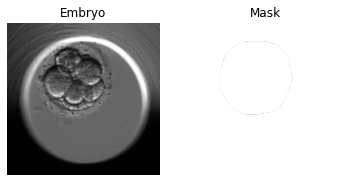

In [93]:
ix = randint(0, len(files))
file_name = files[ix]
n=file_no(file_name)
if(file_name[0]=='M'):
  mask_img = img_arr(path,file_name)
  emb_img = img_arr(path,'Embryo_'+n+'.jpg')
else :
  emb_img = img_arr(path, file_name)
  mask_img = img_arr(path,'Mask_'+n+'.jpg')

img = [emb_img, mask_img]
titles = ["Embryo", "Mask"]
for i in range(2):
  plt.subplot(1,2,i+1)
  plt.imshow(img[i])
  plt.title(titles[i])
  plt.axis("off")  
  




In [56]:
X = []

for file in files:
  if(file[0]=='M'):
    continue
  else :
    try:
      img = Image.open(os.path.join(path, file))
      emb_img =  img_arr(path, file)
      n = file_no(file)
      mask_img = img_arr(path, 'Mask_'+n+'.jpg')
      X.append(file)
    except:
      print("Image not opened!!")

Image not opened!!


In [86]:
class ImageDataset(Dataset):
  def __init__(self, root_dir, X):
    self.root_dir = root_dir
    self.files = os.listdir(self.root_dir)
    self.transform = transform

  def __len__(self):
    return len(X)

  def __getitem__(self, index):
    img_file = X[index]
    n = file_no(img_file)
    emb_img = img_arr(self.root_dir,img_file)
    mask_img = img_arr(self.root_dir, 'Mask_'+n+'.jpg')
    return emb_img, mask_img
    
        


In [87]:
dataset = ImageDataset(path,X)
loader = DataLoader(dataset, batch_size = 16)


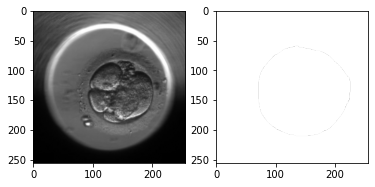

In [88]:
for idx, (x, y) in enumerate(loader):
  plt.subplot(1, 2, 1)
  plt.imshow(x[0])
  plt.subplot(1, 2, 2)
  plt.imshow(y[0])
  break

In [89]:
count = 0
for idx, (x, y) in enumerate(loader):
  count+=x.shape[0]

In [81]:
print(count)

1833


### Trainig of Model

In [118]:
gen = Generator(in_channels = CHANNELS_IMG , features=FEATURES).to(device)
opt = optim.Adam(gen.parameters(), lr=LEARNING_RATE,betas=(0.5, 0.999))
criterion = nn.CrossEntropyLoss()

In [108]:
!pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 5.1 MB/s 
     |████████████████████████████████| 157 kB 67.5 MB/s 
     |████████████████████████████████| 181 kB 72.5 MB/s 
     |████████████████████████████████| 63 kB 2.0 MB/s 
     |████████████████████████████████| 157 kB 74.7 MB/s 
     |████████████████████████████████| 157 kB 65.9 MB/s 
     |████████████████████████████████| 156 kB 71.2 MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=eb8be42b1b55cd824ca5f9ae823e1376e50c9a02a81339e4f633d0f56e0567de
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built pathtools


In [121]:
import wandb
from torchvision.utils import make_grid

In [ ]:
step = 0
gen.train()

In [ ]:
wandb.init("task-02")

for epoch in range(EPOCHS):
  for idx , (emb_img, mask_img) in enumerate(loader):
    emb_img = emb_img.to(device)
    mask_img = mask_img.to(device)
    predicted_mask = gen(emb_img)
    loss = criterion(predicted_mask, mask_img)

    gen.zero_grad()
    loss.gen.backward()
    opt.step()

    
  wandb.log({"LOSS : " : loss, 'epoch' : epoch})  
  with torch.inference_mode():
   for batch_idx, (emb_img, mask_img) in enumerate(loader):
     predicted_mask = gen(emb_img).to(device)
     grid1 = make_grid(emb_img)
     grid2 = make_grid(mask_img)
     grid3 = make_grid(predicted_mask)
     grid1 = wandb.Image(grid1, caption="Original Image")
     grid2 = wandb.Image(grid2, caption="Original Mask ")
     grid3 = wandb.Image(grid2, caption="Predicted Mask")
     wandb.log({"Original Image ": grid1})
     wandb.log({"Original Mask ": grid2})
     wandb.log({"Predicted Mask " : grid3})
